<a href="https://colab.research.google.com/github/vaishnavipatil29/Sign-Language-Recognition/blob/main/Static%20Gesture%20Detection/Alphabets_dig_words_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# American Sign Language Recognition

American Sign Language, typically referred to as ASL, is a visual language characterized
by the formation of manual signs. ASL utilizes a unique form of syntax to communicate
thoughts, feelings, and ideas. Due to discrepancies in census data, the number of American
citizens living within Deaf culture and communicating with ASL is widely disputed. However,
many sources claim that ASL is the third most widely used language in the United States,
following English and Spanish.

The question is, How to reduce the communication gap between the normal people who aren't familiar with ASL and the large community of people having hearing or speech impairments. So, here comes the role of people like us having superpower of technology. Here's a small attempt of me using that superpower to create an AI based system which can recognize as well as translate few static signs in ASL using computer vision.

# Dependencies

In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1BDNB1jirJqrfSbst5dMInbVNhmmtEx-F'})

In [ ]:
download.GetContentFile('dataset.tar')

In [ ]:
!tar xvf dataset.tar

Streaming output truncated to the last 5000 lines.
archive/ASL/A/A_1813.jpg
archive/ASL/A/A_898.jpg
archive/ASL/A/A_429.jpg
archive/ASL/A/A_92.jpg
archive/ASL/A/A_1369.jpg
archive/ASL/A/A_529.jpg
archive/ASL/A/A_799.jpg
archive/ASL/A/A_1469.jpg
archive/ASL/A/A_2494.jpg
archive/ASL/A/A_2365.jpg
archive/ASL/A/A_694.jpg
archive/ASL/A/A_2851.jpg
archive/ASL/A/A_1963.jpg
archive/ASL/A/A_1107.jpg
archive/ASL/A/A_1929.jpg
archive/ASL/A/A_3860.jpg
archive/ASL/A/A_1481.jpg
archive/ASL/A/A_2327.jpg
archive/ASL/A/A_1864.jpg
archive/ASL/A/A_3493.jpg
archive/ASL/A/A_2268.jpg
archive/ASL/A/A_3985.jpg
archive/ASL/A/A_3707.jpg
archive/ASL/A/A_3096.jpg
archive/ASL/A/A_1995.jpg
archive/ASL/A/A_2744.jpg
archive/ASL/A/A_3346.jpg
archive/ASL/A/A_4020.jpg
archive/ASL/A/A_754.jpg
archive/ASL/A/A_3850.jpg
archive/ASL/A/A_2032.jpg
archive/ASL/A/A_1149.jpg
archive/ASL/A/A_3548.jpg
archive/ASL/A/A_2007.jpg
archive/ASL/A/A_456.jpg
archive/ASL/A/A_3620.jpg
archive/ASL/A/A_1430.jpg
archive/ASL/A/A_1671.jpg
archive/

In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle

# Overview of Data

In [ ]:
training_dir="archive/ASL"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['1', '3', '4', '5', '7', '8', '9', 'A', 'B', 'Baby', 'Brother', 'C', 'D', 'Dont_like', 'E', 'F', 'Friend', 'G', 'H', 'Help', 'House', 'I', 'J', 'K', 'L', 'Like', 'Love', 'M', 'Make', 'More', 'N', 'Name', 'No', 'O_OR_0', 'P', 'Pay', 'Play', 'Q', 'R', 'S', 'Stop', 'T', 'U', 'V_OR_2', 'W_OR_6', 'With', 'X', 'Y', 'Yes', 'Z', 'nothing']


51

# Image Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 182700 images belonging to 51 classes.
Found 20300 images belonging to 51 classes.


# Transfer Learning based Model Training

In [ ]:
WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = keras.applications.inception_v3.InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet'
)

inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

# Workflow of InceptionV3 Model

In [ ]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                  
x = layers.Dense(51, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [ ]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()


In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=20,
    callbacks=[callback]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 87/200 [============>.................] - ETA: 45:03 - loss: 4.0632 - acc: 0.0173

KeyboardInterrupt: ignored

In [ ]:
model.save('transferlearning.h5')

# Evaluation Metrics

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

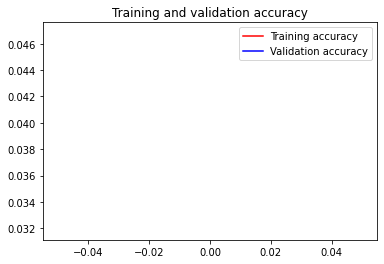

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

In [ ]:
img = cv2.imread('H6.jpg')
img = cv2.resize(img,(200,200))
img = np.reshape(img,[1,200,200,3])

classes = model.predict(img)


In [ ]:
import time

t1 = time.time()
classes = model.predict(img)
t2 = time.time()
print( 'Time taken was {} seconds'.format( t2 - t1))

Time taken was 0.14643597602844238 seconds
